# Using AI modeling to interpret 10-Q filings
As outlined within Investopedia's, [Stock Analysis: Forecasting Revenue and Growth](https://www.investopedia.com/articles/active-trading/022315/stock-analysis-forecasting-revenue-and-growth.asp#:~:text=Analysts%E2%80%99%20forecasts%20are%20crucial%20to%20setting%20expected%20stock,buy%20or%20sell%20a%20stock%20cannot%20be%20made.),  <em>Making forward projections requires numerous inputs; some come from quantitative data and others are more subjective. The reliability and accuracy of the data drive the forecasts</em>.  Much of this information that determines projections, is available within company reports.  While its true that analysts projections are largely driven based on reported metrics, subjective predictions are a result of many factors, including the language and reporting done within company filings reports.

While it is critical to factor all inputs when making forward projections, is it possible to find any correlation with projections based on the interpretation of language within company reports?  By utilizing intelligent models that have been trained on financial data, I will investigate the question of whether the interpretation of financial text can provide any indication of the direction of a given company's outlook.

## Strategic Approach
By utilizing [AI modeling](https://developers.refinitiv.com/en/use-cases-catalog/ai-pipeline), there are a multitude of approaches when formulating a strategy to analyze data with the ability to predict a specific outcome.  A typical analysis will go through a well-defined set of phases from inception and implementation to deployment and continuous improvement. It is an iterative process that can involve several cycles before the solution converges to a finalised pipeline infrastructure. While this process may lead to more focused predictions, it typically involves a greater investment in time and effort.  Instead, I intentionally plan to utilize existing AI models that allow me to investigate if any correlation can be determined without a huge investment.

Using a company's 10-Q - a comprehensive report of the performance that includes relevant information about its financial position - I intend to to perform an analysis of the Management Section defined in each report using the [Forward Looking Statements](https://www.investopedia.com/terms/f/forward-looking.asp#:~:text=%22Forward%20looking%22%20is%20a%20business%20term%20used%20to,to%20buy%20or%20sell%20positions%20in%20the%20company) pre-trained [model](https://huggingface.co/FinanceInc/finbert_fls).  The model was specifically designed to analyze sentences from the *Management Discussion and Analysis* section of annual reports to determine if the text is classified as a Forward Looking Statement. Identifying forward-looking statements from corporate reports can assist investors in financial analysis.

## Getting Started
To setup our analysis, a number of helper modules and packages are defined below that allow me to extract Filings data, capture financial data, manipulate financial text and measure predictions.  To facilitate the ML (Machine Learning) processing, I plan to utilize analysis components available within [Hugging Face](https://huggingface.co/docs/transformers/model_doc/bert) - a popular data science platform to enable the community to build, train and deploy ML models.  In addition, I will employ [Refinitiv's Filings Service](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/filings-API) as the mechanism to query and access text within company 10-Q reporting and use the [Refinitiv Data Library for Python](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python) as the means to access this service.

In [2]:
# NLP package used to aid in text manipulation
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Machine Learning modules used to prepare and measure text
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch

# HTML text processing
from bs4 import BeautifulSoup

# Helper modules
import matplotlib.pyplot as plt
from tqdm.notebook import trange  # Progress bar

# Refinitiv packages to extract filings data and retrieve price data
import refinitiv.data as rd
from refinitiv.data.content import filings

# Convenient modules to simplify API access to Filings
%run ./FilingsQuery.ipynb
%run ./SymbolLookup.ipynb
pd.set_option('display.max_colwidth', 60)

In [3]:
rd.__version__

'1.0.0b27'

In [4]:
# Open a session to retrieve Filings data from RDP
rd.open_session()

<refinitiv.data.session.Definition object at 0x1c0067df790 {name='rdp'}>

### ML modules
For the analysis presented here, I plan to utilize the following pre-trained ML models:
* [Finbert FLS](https://huggingface.co/FinanceInc/finbert_fls)

 A FinBERT model fine-tuned on 3,500 manually annotated sentences from the *Management Discussion and Analysis* section of annual reports of Russell 3000 firms. The model is designed to detect *Forward-looking statements* (FLS) that typically indicate beliefs and opinions about firm's future events or results.
 
* [Finbert Sentiment](https://huggingface.co/ProsusAI/finbert)

 A FinBERT Natural Language Processing (NLP) component to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification.  The goal here is to determine if there is anything indicative when measuring sentiment for the FLS statements within the Filings discussion text.

In [5]:
# Load the models
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-fls',num_labels=3)

Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [6]:
# Download the Pre-trained transformer used to process our raw text
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-fls')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [7]:
# Download the FinBert model used to process our transformed data
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

The *finbert-fls* model was specifically designed to analyze financial text to provide a score for each of the predictive states defined by the model:
* Specific FLS
* Non-specific FLS
* Not FLS

For example, we can feed in any text into the model to demonstrate:

In [8]:
prediction = nlp("The future for next years sales will increase by 10 %.", top_k=3)
prediction

[{'label': 'Specific FLS', 'score': 0.8574218153953552},
 {'label': 'Non-specific FLS', 'score': 0.1353202611207962},
 {'label': 'Not FLS', 'score': 0.007257895078510046}]

The first 2 outcomes (Specific and Non-specific) represent statements that are **Forward Looking Statements**.  However, the main difference is that 'specific' statements can be interpreted as more precise or specific.  For example:

> *The future for next years sales will increase by 10 %.*

The above statement is specific in that it is precise regarding the increase in sales by 10%.

In [9]:
# Conversely, if we change the above statement slightly...
prediction = nlp("The future for next years sales will increase.", top_k=3)
prediction

[{'label': 'Non-specific FLS', 'score': 0.5118423700332642},
 {'label': 'Specific FLS', 'score': 0.4791838228702545},
 {'label': 'Not FLS', 'score': 0.008973869495093822}]

However, the following statement:

> *The future for next years sales will increase.*

leans less against specific and more towards non-specific as it is not clear what the sales increase will be.  In general, non-specific statements can be ambiguous and potentially lead to uncertainty where specific statements provide more confidence and clarity.

#### Sentiment
As part of our analysis, I plan to evaluate the Forward Looking Statement to measure the sentiment of each.  While Forward Looking Statements can provide predictions about future business conditions, these conditions are not necessarily positive.  It might be useful to measure the overall tone of the forward looking statements during the analysis.

In [10]:
# Sentiment - Download the Pre-trained transformer used to process our raw text
sent_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
# Sentiment - Download the FinBert model used to process our transformed data
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

### Filings
The Filings service available within Refinitiv provides the ability to search and extract Global Filings documents for thousands of companies spanning over 50 years of history.  As part of the service, the interface supports the extraction of specific sections within a document.  For example, 10-Q filings are well-structured documents containing specific sections such as Management Discussion, Exhibits, Cashflow Statements, etc.  By utilizing the capabilities offered within the Filings GraphQL interface, I can explicitly choose a specific section for analysis.  Because the <b>entire Filings document</b> is typically complex and contains many standard sections, this will introduce too much insignificant text that may skew the analysis.  Instead, our goal is to utilize the power of the service to choose a specific section that can offer text that may dictate the tone representative of the overall sentiment of the Filing.

#### Filings components
At the heart of the Filings service is a flexible and powerful GraphQL interface that supports the ability to search and select criteria when requesting for documents. While the Filings GraphQL interface does provide significant power when choosing criteria, the formulation of the expressions can be quite terse and intimidating.  To facilitate the use of this interface, a couple of convenient complimentary components have been created to significantly simplify and reduce the time to query the Filings service.  While these components are important and greatly simplify the formulation of queries, I will leave it to the reader to review these interfaces at their leisure for more information.  Additionally, if you want to understand the details around the Filings GraphQL interface as well as the overall service, I would recommend you refer to the [Introduction to Filings](https://developers.refinitiv.com/en/article-catalog/article/introduction-to-filings---python) article.

For the purposes of this workflow, I will describe the general interface capabilities of the supporting components.

<b>FilingsQuery</b><br>
A class that packages up a GraphQL object.  The interface includes some of the more common properties when formulating Filings criteria.  For example:
```
query = FilingsQuery().form_type("10-Q")                   # Defines the Form Type used to query across the Filings database
                      .feed(FilingsQuery.Feed.EDGAR)       # Only look for Filings related to the EDGAR (US SEC)
                      .orgid(1234)                         # Search for a specific company using its organization ID or Perm ID
                      .start_date("2021-05-31T00:00:00Z")  # Filings for a specific date range
                      .end_date("2022-06-30T23:59:59Z")    #
                      .text("BREXIT")                      # Filter documents if it contains specific text
                      .sections(["CashFlowStatement"])     # Extract specific sections of text within the filings
                      .graphQL                             # Process and return the GraphQL string
```

<b>SymbolLookup</b><br>
A class that allows the specification of multiple identifier types to retrieve the organization ID required by the GraphQL service.  For example:
```
orgid = SymbolLookup(ric="AAPL.O").convert()          # RIC       
orgid = SymbolLookup(cusip="037833100").convert()     # CUSIP
orgid = SymbolLookup(isin="US0378331005").convert()   # ISIN
orgid = SymbolLookup(sedol="BH4HKS3").convert()       # SEDOL
orgid = SymbolLookup("AAPL").mic("XNAS").convert()    # Ticker (may require MIC to resolve exchange)
      = SymbolLookup(ticker="AAPL").mic("XNAS").convert()
```

#### Define the input properties required for analysis
There are a number of ways I can collect filings data and the strategy I can use to evaluate the text.  For this analysis, I've chosen to use a single company and capture multiple reports over time.  One thing I considered was that I intentionally avoided mixing filings from multiple companies.  It's quite possible that we may get more accurate results if we focus on the writing style and tone from the same company.

To begin, I'll prepare criteria that acts as the basis for the data sets by choosing a company and a time frame to capture content.

In [12]:
# Use the RIC to define our company identifier
identifier = "TSLA.O"      # Tesla

# Data ranges to capture our data sets used to predict sentiment
start = "2010-01-01T00:00:00Z"
end = "2022-10-31T23:59:59Z"

The Filings API utilizes the *Organization ID* or *Company Perm ID* as the key to locate a specific company.  The following approaches can be used to determine the company of interest.  

Within the desktop:

 * From the search window in the Desktop Taskbar, start typing the name of the company.  For example, using Refinitiv Workspace, start typing and auto-suggest will present matches. When found, hit the "tab" key.  Follow this up by typing "Codes" then hit tab then press "enter" and a screen will show the "Company PermID".
 * Within the desktop, pull up the DIB (Data Item Browser) and locate the field [TR.OrganizationID].  For example, as above, select the company.  In the field input window, type "Organization" and look for TR.OrganizationID.
 
Alternatively:
 * The ID can be determined programmatically using the SymbolLookup component outlined above. I will use *SymbolLookup()* mechanism in the next step.

In [13]:
# Query the Filings service using the Refinitiv Data Library for Python.
#
# Retrieve SEC filings for the specific company - specify the text we want to retrieve
# is defined within the "Management Discussion" section.
response = filings.search.Definition(
    query = FilingsQuery().form_type("10-Q")
                          .orgid(SymbolLookup(ric=identifier).convert())
                          .feed(FilingsQuery.Feed.EDGAR)
                          .sections(["ManagementDiscussion"])
                          .start_date(start)
                          .end_date(end)
                          .limit(100)
                          .graphQL
).get_data()

In [14]:
# Retrieve and report the # of reports based on our query
reports = response.data.raw['data']['FinancialFiling']
organization = reports[0]["FilingOrganization"]['Names']['Name']['OrganizationName'][0]['Name']
len(reports)

38

### Filings text extraction
The above request performed the query to retrieve quarterly SEC filings for the company Tesla.  Within the response contains meta data related to the flings as well as the key information requested - the text containing the "Management Discussion".  At this point, I plan to prepare for the next step of my analysis by extracting this text for each filings document reported.

In [15]:
# Declare our final results table
results = pd.DataFrame()
dates = []
text = []

# Pull out the filings text for each report
for filing in reversed(reports):
    section = filing['FilingDocument']['Sections']['ManagementDiscussion']['Text']
    filingDate = filing['FilingDocument']['DocumentSummary']['FilingDate']
        
    if section is not None:
        dates.append(filingDate[:10])
        
        # Process the text. Using BeautifulSoup and other means to clean the data
        beautifulSoupText = BeautifulSoup(section, "html.parser")
        
        # Clean the data and capture it for later processing
        text.append(beautifulSoupText.prettify(formatter=lambda s: s.replace(u'\xa0', ' ').replace('\r', ' ')))

results['FilingDate'] = dates
results['section'] = text

#### Capture Closing Prices
As part of the analysis, I want to capture the closing price based on the Filings date.  The goal is to look for any possible correlation with the intelligence we extract from the text and the performance of the stock.  While we know performance is based on many factors, the point of this measure is to evaluate one of many possible trends as a way to look for correlation.

In [16]:
# Container to hold the Closing Prices based on the filing date
prices = []

# Walk through the collection of filings and pull out the reported filing date
num_rows = len(results)

for i in trange(num_rows):
    date = results.iloc[i]['FilingDate']
    response = rd.get_data(identifier, ['TR.PriceClose.date', 'TR.PriceClose'], parameters = {'SDate': date, 'EDate': date})
    if not response.empty:
        prices.append(response.iloc[0]['Price Close'])
    else:
        print(f'Unable to retrieve any data price for {identifier}. May be an issue with permissions')

if prices:
    results['close'] = prices
print("**completed**")

  0%|          | 0/21 [00:00<?, ?it/s]

**completed**


In [17]:
results

,FilingDate,section,close
0,2011-05-13,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,1.836665
1,2011-08-12,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,1.753998
2,2011-11-14,19 Table of Contents ITEM 2. MANAGEMENT’S...,2.214664
3,2012-05-10,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,2.197331
4,2012-08-02,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIA...,1.739998
5,2012-11-07,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIA...,2.102665
6,2013-05-10,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIA...,5.117595
7,2013-08-09,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,10.199990
8,2014-05-09,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,12.150655
9,2014-08-08,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,16.541983


### AI model evaluation
For each of the above filings, break down the entire "Management Discussions and Analysis" segment into individual sentences and run each through the pretrained FinBert models to generate our predictions.  The *evaluate()* function below performs the following analysis for each filings report:

For each sentence:
* Evaluate the FLS predictions
* Evaluate the Sentiment

Collect the above FLS results to measure the percentage of sentences that are Forward-looking statements.

In [18]:
def evaluate(filings):
    # Container to hold the percentages of FLS sentences within each filing
    fls_pct = []
    
    # Container to hold the sentiment scores
    scores = []

    # Walk through the collection of filings and feed into the FinBert models
    num_rows = len(filings)

    for i in trange(num_rows):
        # Pull out the "Management Section" text from our filings
        management_section = filings.iloc[i]['section']
  
        # For this section, break it into individual sentences
        sentences = sent_tokenize(management_section)
    
        # Initialize our FLS container
        fls = []
        
        # Define the container to collect stats related to the sentiment scores
        # for all forward-looking statement
        sentiments = torch.Tensor([0,0,0])
        
        # Process each sentence, converting into tokens required by the FinBert model.
        for sentence in sentences:
            # FLS prediction
            prediction = nlp(sentence[:512], top_k=3)[0]['label']

            # Capture FLS statements
            if prediction.startswith("Specific") or prediction.startswith("Non"):
                fls.append(sentence)
                
                # Tokenize - The FinBert model requires tensor-based tokens as input. For any given 
                # sentence, I must ensure the length must does not exceed the models self-imposed limit.
                encoded_input = sent_tokenizer(sentence, return_tensors="pt", truncation=True)
                
                with torch.no_grad():
                    # Run the sentence through the model...
                    output = model(**encoded_input)

                    # The prediction will be in the form of a probability
                    fls_sentiment = torch.nn.functional.softmax(output.logits, dim=-1)

                    # Tally the predictions for each sentence
                    sentiments = sentiments+fls_sentiment
        
        # Record the percentage of FLS sentences
        fls_pct.append(len(fls)/len(sentences)*100)
        
        # Record the resulting sentiment for 'FLS' sentences within this section
        sentiments = sentiments.divide(len(sentences))

        score = model.config.id2label[sentiments.argmax().item()]
        print(f'Filing: {i+1} contains {len(sentences)} sentences of which {len(fls)} are "FLS" with a sentiment of: {sentiments} => {score}')
        scores.append(score)  

    # Add the measures to our results table
    filings['fls_pct'] = fls_pct
    filings[f'fls_sentiment'] = scores

#### Display Graph module
Once we capture our entire data sets, we'll present the results in a detailed graph to determine if we can interpret the results of the predictions presented within our AI models.

In [19]:
# Plot the data
def plot(x_axis, title, y1_label, x2_axis, **kwargs):
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = (17,8)
    
    fig, ax = plt.subplots()
    for label, data in kwargs.items():
        # Special label '_' to plot vertical bar
        if label == '_':
            x = 0
            for s in data:
                plt.axvline(x, ymax=0.25, color=s['color'], label=s['label'], linestyle="--")
                x += 1
        else:
            ax.plot(x_axis, data, label=label)
    
    ax2 = ax.twinx()
    ax2.plot(x_axis, x2_axis, label="Closing Price", color='red')
    
    ax.tick_params(labelrotation=90)
    
    # Remove the spines from the graph - leave the bottom
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add a faint grid
    ax.yaxis.grid(True, alpha=0.2)
    ax.xaxis.grid(True, alpha=0.2)

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    ax.set_ylabel(y1_label, labelpad=12, fontsize=14, color='cyan')
    ax.set_title(title, pad=15, fontsize=16, color='cyan')
    
    if len(kwargs) > 1:
        ax.legend(loc='upper left')
        
    ax2.legend(loc='upper right')

    fig.tight_layout()

In [20]:
def sentiment_bars(scores):
    bars = []
    frequency = {'negative':0, 'neutral':0, 'positive':0}
    
    for s in scores:
        bar = {'color': '', 'label': ''}
        if s == 'negative':
            color = 'red'
        elif s == 'neutral':
            color = 'yellow'
        else:
            color = 'green'
            
        bar['color'] = color
        bar['label'] = s if frequency[s] == 0 else '_'
        frequency[s] += 1
        bars.append(bar)
            
    return bars

### Analysis
With our data, modeling and presentation routines in place, let's begin analysis.  I'll take the results of our filings and run them through the evaluation algorithm to find any correlation.

In [21]:
# Evaluate our predictions and compare against the sentement scores based on the 
# FLS sentences.
evaluate(results)

  0%|          | 0/21 [00:00<?, ?it/s]

Filing: 1 contains 239 sentences of which 78 are "FLS" with a sentiment of: tensor([[0.1109, 0.0442, 0.1713]]) => neutral
Filing: 2 contains 238 sentences of which 69 are "FLS" with a sentiment of: tensor([[0.1100, 0.0321, 0.1479]]) => neutral
Filing: 3 contains 230 sentences of which 72 are "FLS" with a sentiment of: tensor([[0.1083, 0.0353, 0.1694]]) => neutral
Filing: 4 contains 198 sentences of which 59 are "FLS" with a sentiment of: tensor([[0.0888, 0.0582, 0.1510]]) => neutral
Filing: 5 contains 229 sentences of which 71 are "FLS" with a sentiment of: tensor([[0.1054, 0.0681, 0.1366]]) => neutral
Filing: 6 contains 199 sentences of which 48 are "FLS" with a sentiment of: tensor([[0.1002, 0.0456, 0.0954]]) => positive
Filing: 7 contains 193 sentences of which 53 are "FLS" with a sentiment of: tensor([[0.1205, 0.0609, 0.0932]]) => positive
Filing: 8 contains 237 sentences of which 56 are "FLS" with a sentiment of: tensor([[0.0825, 0.0383, 0.1155]]) => neutral
Filing: 9 contains 272

In [22]:
# Display the evaluation results in a tabular format
results

,FilingDate,section,close,fls_pct,fls_sentiment
0,2011-05-13,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,1.836665,32.635983,neutral
1,2011-08-12,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,1.753998,28.991597,neutral
2,2011-11-14,19 Table of Contents ITEM 2. MANAGEMENT’S...,2.214664,31.304348,neutral
3,2012-05-10,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,2.197331,29.797980,neutral
4,2012-08-02,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIA...,1.739998,31.004367,neutral
5,2012-11-07,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIA...,2.102665,24.120603,positive
6,2013-05-10,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIA...,5.117595,27.461140,positive
7,2013-08-09,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,10.199990,23.628692,neutral
8,2014-05-09,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,12.150655,31.250000,neutral
9,2014-08-08,ITEM 2. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCI...,16.541983,30.263158,neutral


Based on each filing, the above evaluation introduced 2 new columns:

* fls_pct
 
 The percentage of sentences that are forward-looking statements.
 
* fls_sentiment

 For the group of forward-looking statements, evaluate the overall sentiment.
 
With our data in place, visualize the results:

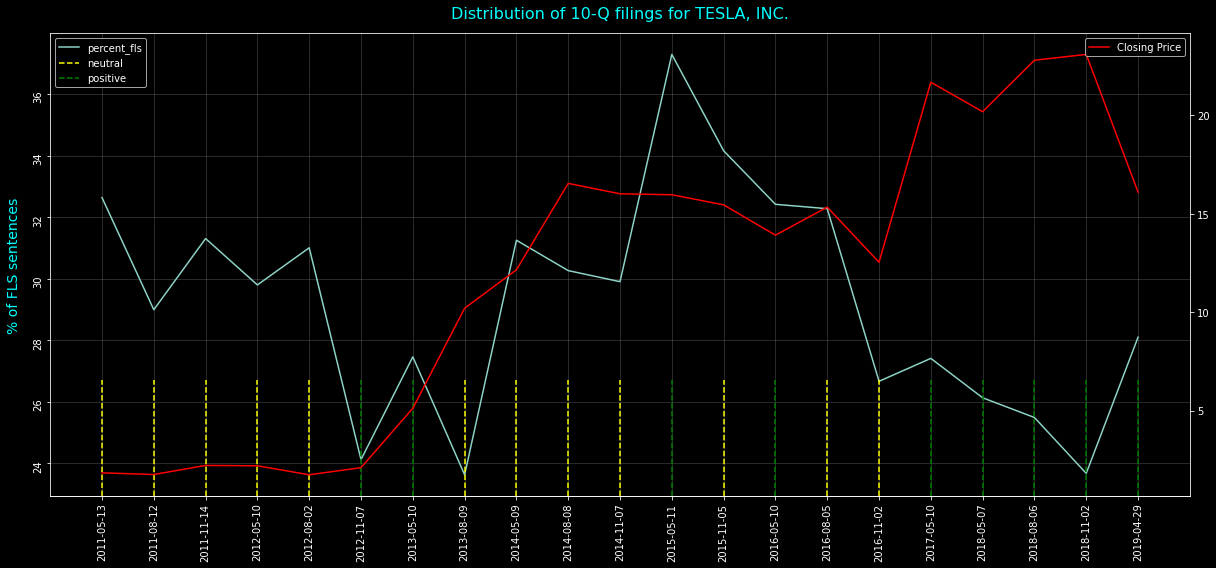

In [24]:
# Visualize the results
plot(results['FilingDate'],
      f"Distribution of 10-Q filings for {organization}",
      '% of FLS sentences',
      results['close'],
      percent_fls=results['fls_pct'],
      _=sentiment_bars(results['fls_sentiment']))

The x-axis represents the dates of each of the 10-Q filings report captured.  On the left y-axis, we can see the percentage of sentences within the filings that are forward-looking statements and on the right y-axis we have plotted a simple closing price measure as a general indicator of performance over time.  Finally, we have plotted vertical bars along the x-axis to indicate our sentiment measures for the forward-looking statements.

The important measure I want to focus on is the trend and measure of our forward-looking statements for each filing.  As I discussed in the opening, analysts predictions can be subjective, especially when reading text.  The above FLS percentage measure can be interpreted in a number of ways.  For example, if we have a low percentage of FLS statements, does that imply vague outlook? Does a relatively higher percentage of FLS statements indicate confidence?  How do these measures stack up to the stock performance based on the single closing price value?  As expected, it is likely too ambitious to expect a single factor, such as measuring text from a filings report, to provide sound future predictions. Finally, I included a sentiment score for each filing as a possible way to ingest additional analysis into the picture.  In general, all scores fall into the neutral or positive sphere.  As with price, the interpretation of this measure may not be enough to predict any specific outcome.

## Conclusion

What is the general takeaway from the above analysis?  I would suggest that the FLS measurements may provide some very interesting output that requires in-depth research.  While it is interesting to plot the performance of the stock and the general sentiment scores, neither of these basic measures appear to provide any correlation, especially if I attempt to analyze multiple companies.  However, that does not mean further research may not provide more interesting results.  For example, can we capture the time series of the stock over a 10-day period to measure the immediate effect of the filings release?  Possibly introducing a [vector autoregression](https://en.wikipedia.org/wiki/Vector_autoregression) statistical analysis may be an option that could possible unearth meaningful correlation.